In [1]:
import pandas as pd
import numpy as np
import requests
import os
import json
import ijson
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path
from tqdm import tqdm
from tqdm.auto import tqdm
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from surprise import Dataset, Reader, SVD, KNNBasic, accuracy, SlopeOne
from surprise.model_selection import GridSearchCV
from implicit.bpr import BayesianPersonalizedRanking

/Users/jacobsilver/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Introduction

For this project, I will be using Goodreads data (https://cseweb.ucsd.edu/~jmcauley/datasets/goodreads.html) to build a book recommendation engine. The researchers who have curated this data helpfully split it up into different genres, and due to the limitations of working with very large data in a local environment, I will be building only off of the comic/graphic novel data. While genre spread is often a way recommender systems seek to maximize outside of accuracy, such as through diversity or serendipity, there is a great deal of variability even within particular genres (consider for example, the tonal difference between a teen-focused Spiderman comic as opposed to *Maus*, a postmodern Holocaust analogy).

This is also an area of book sales that may see special benefit from optimizations beyond accuracy. Pure similarity may select for the appearance of particular superheroes, who tend to recur and intersect across many different storylines (I mean, think of how hard it is to keep up with Marvel movies!), or even within the same series. It is easy to imagine a recommender system over-indexing on particular characters or series at the expense of exploration and new frontiers.

Nonetheless, we will begin with a content-based system leveraging the description 'blurbs' included in the book data. But first, let's pull in the data and get an understanding of its contents.

In [2]:
#os.listdir('data_comics')

**Books data:**

In [3]:
#Books data + metadata fields
df_b = pd.read_json('data_comics/goodreads_books_comics_graphic.json', lines=True)

In [4]:
df_b.head()

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,,1,[],US,,"[{'count': '228', 'name': 'to-read'}, {'count'...",B00NLXQ534,true,4.12,,...,,,,https://www.goodreads.com/book/show/25742454-t...,https://s.gr-assets.com/assets/nophoto/book/11...,25742454,1,42749946,The Switchblade Mamma,The Switchblade Mamma
1,2205073346,2,[],US,fre,"[{'count': '2', 'name': 'bd'}, {'count': '2', ...",,false,3.94,,...,1,,2016,https://www.goodreads.com/book/show/30128855-c...,https://images.gr-assets.com/books/1462644346m...,30128855,16,50558228,Cruelle,Cruelle
2,,5,"[246830, 362583, 362581, 623032]",US,eng,"[{'count': '493', 'name': 'to-read'}, {'count'...",,false,4.28,,...,,,2012,https://www.goodreads.com/book/show/13571772-c...,https://images.gr-assets.com/books/1333287305m...,13571772,51,102217,Captain America: Winter Soldier (The Ultimate ...,Captain America: Winter Soldier (The Ultimate ...
3,,1,[],US,eng,"[{'count': '222', 'name': 'to-read'}, {'count'...",B06XKGGSB7,true,4.05,B06XKGGSB7,...,,,,https://www.goodreads.com/book/show/35452242-b...,https://s.gr-assets.com/assets/nophoto/book/11...,35452242,6,54276229,Bounty Hunter 4/3: My Life in Combat from Mari...,Bounty Hunter 4/3: My Life in Combat from Mari...
4,0930289765,6,"[266759, 1096220]",US,en-US,"[{'count': '20', 'name': 'to-read'}, {'count':...",,false,4.06,,...,11,,1997,https://www.goodreads.com/book/show/707611.Sup...,https://images.gr-assets.com/books/1307838888m...,707611,51,693886,"Superman Archives, Vol. 2","Superman Archives, Vol. 2"


There is a lot of information contained here which, while interesting, is not material either to building a recommender or understanding its outputs. Let's filter down only the most important fields: isbn and book_id (identifiers), description (the text field we'll use to define book similarity), and a few additional fields of analytical interest:

In [5]:
#paring down cols but retaining some basic information that might be worth analyzing
df_b = df_b[['isbn', 'country_code', 'language_code', 'average_rating',
      'description', 'authors','num_pages', 'publication_year',
      'book_id', 'ratings_count',  'title']]

In [6]:
df_b.head()

,isbn,country_code,language_code,average_rating,description,authors,num_pages,publication_year,book_id,ratings_count,title
0,,US,,4.12,Lillian Ann Cross is forced to live the worst ...,"[{'author_id': '8551671', 'role': ''}]",,,25742454,1,The Switchblade Mamma
1,2205073346,US,fre,3.94,"Florence Dupre Latour raconte comment, de son ...","[{'author_id': '3274315', 'role': ''}]",,2016,30128855,16,Cruelle
2,,US,eng,4.28,The questions plaguing Captain America's dream...,"[{'author_id': '37450', 'role': ''}]",146,2012,13571772,51,Captain America: Winter Soldier (The Ultimate ...
3,,US,eng,4.05,The fight for Jason Delgado's life and soul be...,"[{'author_id': '16209952', 'role': ''}, {'auth...",,,35452242,6,Bounty Hunter 4/3: My Life in Combat from Mari...
4,0930289765,US,en-US,4.06,These are the stories that catapulted Superman...,"[{'author_id': '81563', 'role': ''}, {'author_...",272,1997,707611,51,"Superman Archives, Vol. 2"


In [7]:
df_b['country_code'].value_counts()

country_code
US    89411
Name: count, dtype: int64

<Axes: xlabel='language_code'>

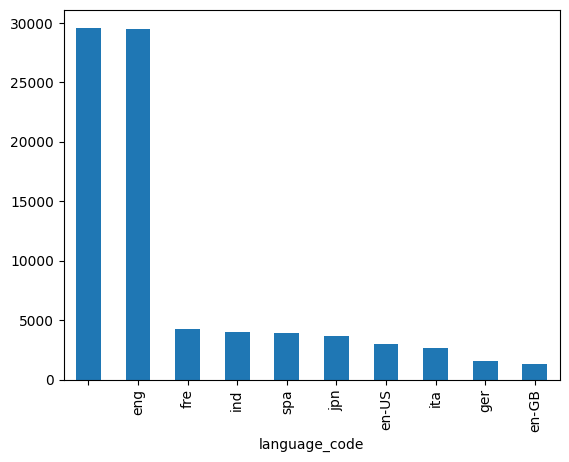

In [8]:
df_b['language_code'].value_counts()[:10].plot(kind='bar')

We can see that according to the data, all of the books are from the US, though there is greater linguistic spread. A slight plurality of books do not have a language marked, while most of the marked books are in English. That said, there are thousands of entries in French, Indonesian, Spanish, Japanese and more. 

<Axes: >

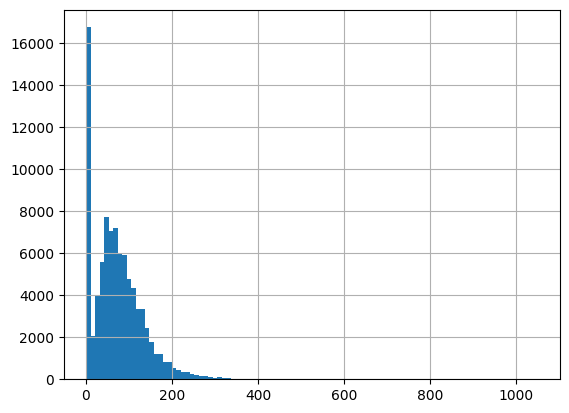

In [9]:
#histogram of rough word count
df_b['description'].apply(lambda x: len(x.split(' '))).hist(bins=100)

We have a rather normal distribution of wordcounts, though there are clearly a large number of books with a null description. Since we are depending on that field to gauge similarity, we'll need to filter out books with that quality, both from our books data and in the ratings data below.

In [10]:
df_b = df_b[df_b['description'].apply(len)!=0]

<Axes: >

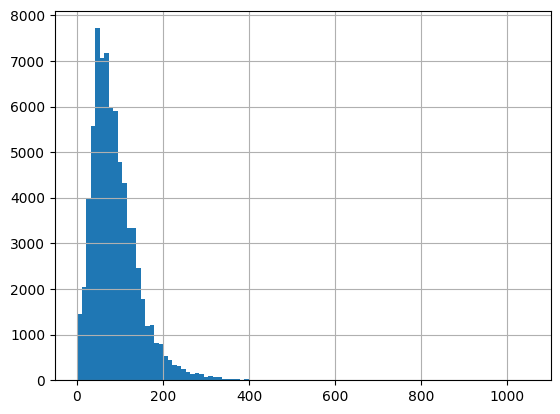

In [11]:
df_b['description'].apply(lambda x: len(x.split(' '))).hist(bins=100)

Much better--we can see that the standard description contains 100-200 words or so. Here's a brief sampling of them:

In [12]:
for i in range(0, 3):
    print(str.upper(df_b.sample(5, random_state=905)[['title','description']].iloc[i,0]))
    print(df_b.sample(5, random_state=905)[['title','description']].iloc[i,1])

SHIRLEY JACKSON'S "THE LOTTERY": THE AUTHORIZED GRAPHIC ADAPTATION
The classic short story--now in full color
Shirley Jackson's "The Lottery" continues to thrill and unsettle readers nearly seven decades after it was first published. By turns puzzling and harrowing, it raises troubling questions about conformity, tradition, and the specter of ritualized violence that haunts even the most bucolic, peaceful village. This graphic adaptation, published in time for Jackson's centennial, allows readers to experience "The Lottery" as never before, or discover it anew. The visual artist--and Jackson's grandson--Miles Hyman has crafted an eerie vision of the hamlet where the tale unfolds, its inhabitants, and the unforgettable ritual they set into motion. His four-color, meticulously detailed panels create a noirish atmosphere that adds a new dimension of dread to the original tale. Perfectly timed to the current resurgence of interest in Jackson and her work, Shirley Jackson's "The Lottery": T

Here we can already get a sense of the rich texture of these descriptions, and some of the vibes ("eerie", "quasi-historical", "legendary") that different snippets seek to convey.

**Ratings Data:**

Because the ratings data is significantly bigger, it needs to be imported in chunks.

In [13]:
chunks = pd.read_json(
    'data_comics/goodreads_interactions_comics_graphic.json',
    lines=True,
    chunksize=25_000
)

# if you don’t know the total up front, tqdm will just show an indeterminate spinner
df_i = pd.concat(
    tqdm(chunks, desc='Loading JSON chunks', total=294),
    ignore_index=True
)

Loading JSON chunks: 100%|████████████████████| 294/294 [03:22<00:00,  1.45it/s]


In [14]:
df_i.head()

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,836610,6b4db26aafeaf0da77c7de6214331e1e,False,0,,Mon Aug 21 12:11:00 -0700 2017,Mon Aug 21 12:11:00 -0700 2017,,
1,8842281e1d1347389f2ab93d60773d4d,7648967,99b27059f711c37de8f90ee8e4dc0d1b,False,0,,Fri Feb 24 08:59:44 -0800 2017,Fri Feb 24 08:59:44 -0800 2017,,
2,8842281e1d1347389f2ab93d60773d4d,15704307,cb944d94854df5afd22210bb0aa0c903,False,0,,Wed May 20 21:28:56 -0700 2015,Wed May 20 21:28:57 -0700 2015,,
3,8842281e1d1347389f2ab93d60773d4d,6902644,2711bac2a8cc600dae1590a6ca0edb34,False,0,,Sun Jun 01 17:25:23 -0700 2014,Sun Jun 01 17:25:23 -0700 2014,,
4,8842281e1d1347389f2ab93d60773d4d,9844623,b72979076d1cded25dded922195e5b1c,False,0,,Sun Sep 02 08:45:08 -0700 2012,Sun Sep 02 08:45:08 -0700 2012,,


The ratings data is less cluttered, but still, for our purposes all we need is a the user_id for the user giving a rating, the book_id of the rated book and the rating itself.

In [15]:
#reducing to only user, book and rating
df_i = df_i[['user_id','book_id','rating']]

Now we need to filter this data down, both for reasonability and size. We can start by eliminating any reviews of the books we took out of the books data for lacking a description:

In [27]:
df_i = df_i[df_i['book_id'].isin(df_b['book_id'])]

Now let's get a quick sense of the rating scale and how the ratings themselves shake out:

<Axes: >

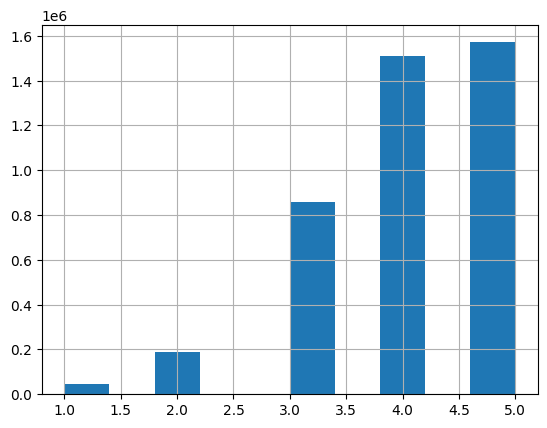

In [28]:
df_i['rating'].hist()

Two major takeaways from the above. One is that the ratings themselves skew high (most are 4s and 5s), possibly speaking to the fandom-driven nature of the comic and graphic novel genres. In order to understand if that's a true effect, we'd need to pull in the data for other genres, which is out of scope for this analysis.

**More importantly for the task at hand**, there is a proliferation of "0" ratings. Desk research shows that Goodreads does not offer the option to give zero stars, so we're left to understand that these are actually null values that we can filter out, as they don't provide useful numerical data on which to train our model.

In [29]:
df_i = df_i[df_i['rating']>0]

Next, we'll set some thresholds for the minimum amount of ratings required of a user. These thresholds correspond roughly to the 80th percentile for each variable, meaning we retain the bulk of useful information while cutting off a long tail that could make our system too noisy.

In [30]:
MIN_BOOK_RATINGS = 50
MIN_USER_RATINGS = 20

df_i2 = df_i.copy()

while True:
    before = df_i2.shape[0]
    
    #drop books with too few reviews
    df_i2 = df_i2.groupby('book_id').filter(lambda x: len(x) >= MIN_BOOK_RATINGS)
    #drop users with too few reviews
    df_i2 = df_i2.groupby('user_id').filter(lambda x: len(x) >= MIN_USER_RATINGS)
    
    after = df_i2.shape[0]
    if after == before:
        break

print(f"Final: {df_i2.user_id.nunique()} users, {df_i2.book_id.nunique()} books, {len(df_i2)} interactions")

Final: 35022 users, 11068 books, 2628384 interactions


Now we can re-filter our books data to account for these changes as well:

In [31]:
df_b2 = df_b[df_b['book_id'].isin(df_i2['book_id'].value_counts().index)]

EDA

<Axes: >

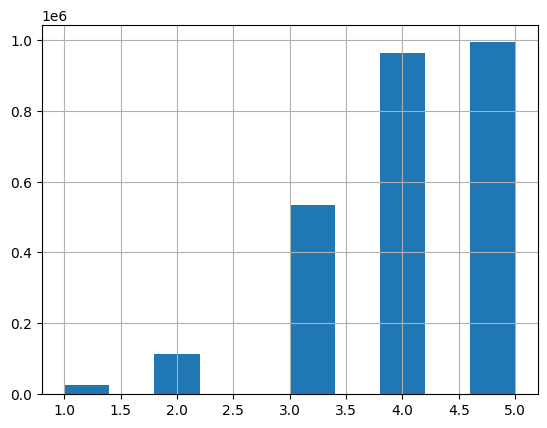

In [32]:
df_i2['rating'].hist()

In [33]:
#tk tk 

In [34]:
#tk tk 

#### Content-Based Recommender with TF-IDF Similarity

Now we can begin building our first recommendation system: a content-based recommender based on the similarity of descriptions.

In [37]:
#reset index
df_i2 = df_i2.reset_index().drop(columns='index')
#filter to only positive ratings for test data (since we'll be looking predicting top-K recs)
df_pos = df_i2[df_i2['rating']>=4]
#build test data by removing one review per user
test_i = df_pos.groupby('user_id').sample(n=1, random_state=905)
#preserve those removed reviews as test data
train_i = df_pos.drop(test_i.index)
print(f"Train size: {len(train_i)}, Test size: {len(test_i)}")

Train size: 1921081, Test size: 34969


Let's run some routine text cleaning before building our TF-IDF vectors:

In [38]:
df_b2['clean_desc'] = (
    df_b2['description']
       .fillna('')
       .str.lower()
       .str.replace(r'[^a-z0-9\s]', ' ', regex=True)
       .str.split()
       .apply(lambda toks: [t for t in toks if len(t)>2])
       .apply(lambda toks: ' '.join(toks))
)

/var/folders/sk/5p5s43w94rlf_9j_h77yytpc0000gn/T/ipykernel_68349/448535004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b2['clean_desc'] = (


In [39]:
#build a TF-IDF vectorizer with up to 10k features
tfidf = TfidfVectorizer(max_features=10_000)
#convert our clean description column into numerical vectors weighted by TF-IDF
X_tfidf = tfidf.fit_transform(df_b2['clean_desc'])

#preserve book indices
book_idx = {book_id: i for i, book_id in enumerate(df_b2['book_id'])}

#build similarity matrix based on cosine similarity for every book with one another
item_sim = cosine_similarity(X_tfidf, X_tfidf)

In [40]:
#build user -> list of (item_idx, rating)
user_ratings = {}
for _, row in train_i.iterrows():
    u, b, r = row['user_id'], row['book_id'], row['rating']
    idx = book_idx.get(b)
    if idx is not None:
        user_ratings.setdefault(u, []).append((idx, r))

#save global_mean
global_mean = train_i['rating'].mean()

Next is the bulk of the training and model running, with an eye toward three main metrics:
- Recall@K, which tells us how often our held-out, positive rating appears among the K recommendations for each user.
- NDCG@K (Normalized Discounted Cumulative Gain), which is similar to Recall@K, but is weighted to reward the test item appearing more highly in the rankings.
- ILD@K (Intra-List Diversity), which measures how different the K recommendations provided for individual users are from each other. This is not an accuracy metric per se, but in practice a higher score for this metric may lead to better recommendations by ensuring they are not too similar/boring or over-indexing on a particular observed preference.

In [41]:
#prep: train‐seen map and parameters
train_seen = {u: {idx for idx,_ in user_ratings[u]} for u in user_ratings}
#will ultimately use 10 as target list size for recommendations
K = 10
pool_size = 5 * K

#fit TF-IDF KNN to id "neighbors" of each book based on cosine similarity
knn_tfidf_base = NearestNeighbors(
    n_neighbors=pool_size,
    metric='cosine',
    algorithm='brute',
    n_jobs=-1
)
knn_tfidf_base.fit(X_tfidf)

#baseline ranking
recall_base, ndcg_base, ild_base = [], [], []

for u, ratings in tqdm(user_ratings.items(), desc="Evaluating TF-IDF Base"):
    #build user profile
    idxs = [idx for idx, _ in ratings]
    rts = np.array([r for _, r in ratings], dtype=float)
    M_user = X_tfidf[idxs]
    weighted = M_user.T.dot(rts)
    profile = weighted / rts.sum()

    #get same pool of candidates via cosine‐KNN
    dists, neighs = knn_tfidf_base.kneighbors(
        profile.reshape(1, -1), return_distance=True
    )
    all_cands    = neighs.ravel().tolist()

    #only consider unseen candidates
    unseen_cands = [i for i in all_cands if i not in train_seen[u]]

    #take the first K as baseline recommendations
    rec_base = unseen_cands[:K]

    #locate held-out test index
    test_book = test_i.loc[test_i['user_id']==u, 'book_id'].iloc[0]
    test_idx  = book_idx[test_book]

    #Recall@K
    recall_base.append(int(test_idx in rec_base))

    #NDCG@K
    if test_idx in rec_base:
        pos = rec_base.index(test_idx)
        ndcg_base.append(1.0 / np.log2(pos + 2))
    else:
        ndcg_base.append(0.0)

    # H) ILD@K
    M = len(rec_base)
    if M > 1:
        sims_sub = item_sim[np.ix_(rec_base, rec_base)]
        diss     = (1 - sims_sub)[np.triu_indices(M, k=1)].sum()
        ild_base.append((2.0 / (M*(M-1))) * diss)
    else:
        ild_base.append(0.0)

# ── 4) Print baseline metrics ─────────────────────────────────────────────
print(f"▶ Recall@{K} Base : {np.mean(recall_base):.4f}")
print(f"▶ NDCG@{K}    Base : {np.mean(ndcg_base):.4f}")
print(f"▶ ILD@{K}     Base : {np.mean(ild_base):.4f}")


Evaluating TF-IDF Base: 100%|█████████████| 34926/34926 [59:29<00:00,  9.78it/s]

▶ Recall@10 Base : 0.1361
▶ NDCG@10    Base : 0.0753
▶ ILD@10     Base : 0.7506


While 13.61% would be very low recall for some ML systems, for a recommender like this it is actually quite high! Our NDCG is decent as well, and the ILD suggests pretty strong diversity in the recommendations.

Next, we'll build a light-weight collaborative filtering model using the surprise package, chosen specifically for its efficiency with moderately large data. (Full disclosure, my attempts to use other CF methdodologies including matrix factorizations resulted in crashed notebook kernels).

#### Collaborative Filtering with Surprise

In [46]:
#build surprise train/test sets
r_min, r_max = train_i['rating'].min(), train_i['rating'].max()
reader = Reader(rating_scale=(r_min, r_max))

trainset = Dataset.load_from_df(
    train_i[['user_id','book_id','rating']],
    reader
).build_full_trainset()

#test dataframe
test_df = test_i[['user_id','book_id','rating']]

#initialize and train SlopeOne model
algo = SlopeOne()
algo.fit(trainset)

#get training history & global mean
train_hist = train_i.groupby('user_id')['book_id'].apply(set).to_dict()
global_mean = train_i['rating'].mean()

#overall book popularity for candidate restriction
popularity = train_i['book_id'].value_counts()
popular_books = popularity.index.tolist()

#ranking‐based evaluation
K = 10
recall_list, ndcg_list, ild_list = [], [], []

#also need book_ids and a small helper for ILD
all_books = df_b2['book_id'].tolist()

for u in tqdm(train_hist.keys(), desc="Evaluating SlopeOne"):
    seen = train_hist[u]
    #build candidate list: most popular unseen books
    #(this restriction makes it ~1000 predictions per user)
    cands = [b for b in popular_books if b not in seen][:1000]

    #score each candidate
    scores = []
    for b in cands:
        pred = algo.predict(u, b).est
        scores.append((b, pred))
    #take top-K by score
    topk = [b for b,_ in sorted(scores, key=lambda x: x[1], reverse=True)[:K]]

    #held-out test book for this user
    true_b = test_df.loc[test_df['user_id']==u, 'book_id'].iloc[0]

    #Recall@K
    recall_list.append(int(true_b in topk))

    #NDCG@K
    if true_b in topk:
        pos = topk.index(true_b)
        ndcg_list.append(1.0 / np.log2(pos + 2))
    else:
        ndcg_list.append(0.0)

    #ILD@K using existing TF-IDF item_sim
    #convert topk book_ids to their indices in df_b2
    idxs = [book_idx[b] for b in topk]
    sims = item_sim[np.ix_(idxs, idxs)]
    M    = len(idxs)
    diss = (1 - sims)[np.triu_indices(M, k=1)].sum()
    ild_list.append((2.0 / (M*(M-1))) * diss)

#metrics
print(f"▶ Recall@{K}: {np.mean(recall_list):.4f}")
print(f"▶ NDCG@{K}:   {np.mean(ndcg_list):.4f}")
print(f"▶ ILD@{K}:    {np.mean(ild_list):.4f}")

Evaluating SlopeOne: 100%|████████████████| 34926/34926 [24:40<00:00, 23.58it/s]

▶ Recall@10: 0.0120
▶ NDCG@10:   0.0063
▶ ILD@10:    0.8558


This is an interesting result. Compared to my content-based model, this collaborative-filtering approach achieved **much** lower accuracy in terms of both recall and NDCG. However, the results were much more diverse on a user-by-user basis. This is likely because, for the sake of performance, I limited the model to only the top 1000 most popular books in the data, severely limiting potential matches outside of that set. At the same time, there may be a natural level of diversity among that biased sample of popular books, contributing to a high ILD down the recommendation pipeline.

Now, I want to see if I can strike an even better balance overall, by improving the diversity of my content-based model (without sacrificing much accuracy) and improving the accuracy of my CF model (without sacrificing much diversity).

#### Improving Accuracy-Diversity Balance

My process for improving the diversity of my content-based model is to use Maximal Marginal Relevance (MMR), which is a new step that can be injected into the recommendation process. Essentially, it allows for re-ranking of recommendations to optimize the diversity of selections. 

In [70]:
#mmr function
def mmr_rerank(candidates, base_scores, item_vecs, lambda_div=0.5, top_n=K):
    selected = []
    pool = candidates.copy()
    while len(selected) < top_n and pool:
        mmr_vals = {}
        for i in pool:
            rel = base_scores[i]
            if not selected:
                mmr_vals[i] = lambda_div * rel
            else:
                div = max(np.dot(item_vecs[i], item_vecs[j]) for j in selected)
                mmr_vals[i] = lambda_div * rel - (1 - lambda_div) * div
        best = max(mmr_vals, key=mmr_vals.get)
        selected.append(best)
        pool.remove(best)
    return selected

In [71]:
#prepare what each user has seen and set parameters
train_seen = {u: {idx for idx,_ in user_ratings[u]} for u in user_ratings}
K = 10
pool_size = 5 * K

#build new KNN on TF-IDF vectors
knn_tfidf_mmr = NearestNeighbors(
    n_neighbors=pool_size,
    metric='cosine',
    algorithm='brute',
    n_jobs=-1
)
knn_tfidf_mmr.fit(X_tfidf)

#evaluate TF-IDF + MMR for each user (with ILD guard)
recall_mmr2, ndcg_mmr2, ild_mmr2 = [], [], []

for u, ratings in tqdm(user_ratings.items(), desc="Evaluating TF-IDF + MMR"):
    # 1) Build the user profile
    idxs = [idx for idx, _ in ratings]
    rts = np.array([r for _, r in ratings], dtype=float)
    M_user = X_tfidf[idxs]
    weighted = M_user.T.dot(rts)
    profile  = weighted / rts.sum()

    #get pool_size nearest TF-IDF neighbors
    dists, neighs = knn_tfidf_mmr.kneighbors(profile.reshape(1, -1),
                                               return_distance=True)
    all_cands = neighs.ravel().tolist()

    #filter out seen items
    unseen_cands    = [i for i in all_cands if i not in train_seen[u]]

    #compute base TF-IDF scores & normalized candidate vectors
    base_scores = {i: float(profile.dot(X_tfidf[i].toarray().ravel()))
                   for i in unseen_cands}
    item_vecs = {}
    for i in unseen_cands:
        v = X_tfidf[i].toarray().ravel()
        item_vecs[i] = v / np.linalg.norm(v)

    #MMR re-rank down to top-K
    rec_sorted = mmr_rerank(
        candidates=unseen_cands,
        base_scores=base_scores,
        item_vecs=item_vecs,
        lambda_div=0.5,
        top_n=K
    )

    #Locate held-out test item index
    test_book = test_i.loc[test_i['user_id']==u, 'book_id'].iloc[0]
    test_idx  = book_idx[test_book]

    #Recall@K
    recall_mmr2.append(int(test_idx in rec_sorted))

    #NDCG@K
    if test_idx in rec_sorted:
        pos = rec_sorted.index(test_idx)
        ndcg_mmr2.append(1.0 / np.log2(pos + 2))
    else:
        ndcg_mmr2.append(0.0)

    #ILD@K with zero-division guard
    M = len(rec_sorted)
    if M > 1:
        sims_sub = item_sim[np.ix_(rec_sorted, rec_sorted)]
        diss     = (1 - sims_sub)[np.triu_indices(M, k=1)].sum()
        ild_mmr2.append((2.0 / (M * (M - 1))) * diss)
    else:
        ild_mmr2.append(0.0)

#metrics
print(f"▶ Recall@{K} (MMR): {np.mean(recall_mmr2):.4f}")
print(f"▶ NDCG@{K}   (MMR): {np.mean(ndcg_mmr2):.4f}")
print(f"▶ ILD@{K}    (MMR): {np.mean(ild_mmr2):.4f}")

Evaluating TF-IDF + MMR: 100%|████████████| 34926/34926 [18:30<00:00, 31.45it/s]

▶ Recall@10 (MMR): 0.0977
▶ NDCG@10   (MMR): 0.0618
▶ ILD@10    (MMR): 0.8552


Using MMR, I was indeed able to boost my ILD score. However, accuracy went down notably in the process. Overall, I'm not sure the losses to recall are worth the 10-point gain in ILD, but I would need to spend more time in the system to truly be able to know. It is only through long-term observation that we can observe the potential gains from diversity, such as the non-attrition of graphic novel fans who are excited short-term for accurate recommendations, but become less engaged over time due to boredom.

Let's now see if we can achieve higher accuracy with our collaborative-filtering system, which already had a diversity score at the same level as our MMR-infused content-based system. I'll tune the model by increasing the number of top-books considered from 1000 to 2000:

In [72]:
#build surprise train/test sets
r_min, r_max = train_i['rating'].min(), train_i['rating'].max()
reader = Reader(rating_scale=(r_min, r_max))

trainset = Dataset.load_from_df(
    train_i[['user_id','book_id','rating']],
    reader
).build_full_trainset()

#test dataframe
test_df = test_i[['user_id','book_id','rating']]

#initialize and train SlopeOne model
algo = SlopeOne()
algo.fit(trainset)

#get training history & global mean
train_hist = train_i.groupby('user_id')['book_id'].apply(set).to_dict()
global_mean = train_i['rating'].mean()

#overall book popularity for candidate restriction
popularity = train_i['book_id'].value_counts()
popular_books = popularity.index.tolist()

#ranking‐based evaluation
K = 10
recall_list, ndcg_list, ild_list = [], [], []

#also need book_ids and a small helper for ILD
all_books = df_b2['book_id'].tolist()

for u in tqdm(train_hist.keys(), desc="Evaluating SlopeOne"):
    seen = train_hist[u]
    #build candidate list: most popular unseen books
    #(this restriction makes it ~1000 predictions per user)
    cands = [b for b in popular_books if b not in seen][:2000]

    #score each candidate
    scores = []
    for b in cands:
        pred = algo.predict(u, b).est
        scores.append((b, pred))
    #take top-K by score
    topk = [b for b,_ in sorted(scores, key=lambda x: x[1], reverse=True)[:K]]

    #held-out test book for this user
    true_b = test_df.loc[test_df['user_id']==u, 'book_id'].iloc[0]

    #Recall@K
    recall_list.append(int(true_b in topk))

    #NDCG@K
    if true_b in topk:
        pos = topk.index(true_b)
        ndcg_list.append(1.0 / np.log2(pos + 2))
    else:
        ndcg_list.append(0.0)

    #ILD@K using existing TF-IDF item_sim
    #convert topk book_ids to their indices in df_b2
    idxs = [book_idx[b] for b in topk]
    sims = item_sim[np.ix_(idxs, idxs)]
    M    = len(idxs)
    diss = (1 - sims)[np.triu_indices(M, k=1)].sum()
    ild_list.append((2.0 / (M*(M-1))) * diss)

#metrics
print(f"▶ Recall@{K}: {np.mean(recall_list):.4f}")
print(f"▶ NDCG@{K}:   {np.mean(ndcg_list):.4f}")
print(f"▶ ILD@{K}:    {np.mean(ild_list):.4f}")

Evaluating SlopeOne: 100%|████████████████| 34926/34926 [23:15<00:00, 25.03it/s]

▶ Recall@10: 0.0103
▶ NDCG@10:   0.0056
▶ ILD@10:    0.8880


We do not see a Recall increase from this attempt, although interesting there appears to be a bit more diversity. Unfortunately, memory constraints preclude more comprehensive tuning, though the baseline accuracy is low enough that this model is unlikely to surpass our robust content-based recommender all told.

#### Conclusion

In the end, I believe my best bet is to go with my content-based model, but continue to monitor it to ensure that diversity never falls far below its current levels of ~0.75. This is because when it comes to comics and graphic novels, I'm likely to see diminishing returns from continuing to recommend highly similar editions. Sure, a fan of Watchmen author Alan Moore (such as myself) is likely to enjoy V for Vendetta, as well as other gritty graphic novels by him and other authors with similar sensibilities. But tastes change over time, and even if they didn't there is not an unlimited supply of such titles. At some point, I would want that customer to tap into other aspects of what they enjoy, such as more 'sincere' superhero titles, or more non-superhero related graphic novels and comics. And of course, with a more performant set up, I would love to expand beyond comics/graphic novels into other genres entirely.

As for additional experiments and metrics using online data, I would want to a.) ensure that diversity is prioritized in my model, but b.) measure user behavior to determine whether users are indeed selecting and eventually rating the "diverse" options they are served. In my offline data, I take for granted that diversity is a potential virtue for long-term customer satisfaction. However, comics and graphic novels are, more-so than other genres, heavily fandom driven. That means there may actually be less demand for diverse options and, unlike say, movies (where franchises are lucky to get a trilogy) there is actually enough supply to keep people happy long term. There are over 1000 titles mentioning "Batman" in this data alone!

In [75]:
len(df_b[df_b['title'].apply(lambda x: 'batman' in str.lower(x))])

1595